In [1]:
!pip3 install torchrl
!pip3 install gymnasium[mujoco]
!pip3 install tqdm

In [2]:
# Torch
import torch
from tensordict.nn import TensorDictModule, InteractionType
from tensordict.nn.distributions import NormalParamExtractor

# Tensordict modules
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import TransformedEnv
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs
from torchrl.envs.transforms import DoubleToFloat

# Model and policy
from torchrl.modules import MLP, ProbabilisticActor, TanhNormal, ValueOperator
# Loss
from torchrl.objectives import SoftUpdate
from torchrl.objectives.sac import SACLoss

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

In [3]:
# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
print(device)
gym_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration
n_iters = 2*200  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 20  # Number of optimization steps per training iteration
minibatch_size = 300  # Size of the mini-batches in each optimization step
lr_actor = 6e-4  # Learning rate
lr_critic = lr_actor  # Learning rate

# SAC
value_loss='smooth_l1' # 'smooth_l1' 'l2'; loss function to be used with the value function loss
gamma = 0.99  # discount factor
polyak = 0.995 # lambda for generalised advantage estimation

# Model
layers_config = [512, 256, 128, 64]  # Number of units per layer in the network

# GYM
scenario_name = "HumanoidStandup-v4"
max_steps = 400

env = GymEnv(
    env_name=scenario_name,
    device=gym_device,
)

# transform the environment to a float32 tensor
env = TransformedEnv(
    env,
    transform=DoubleToFloat(),
    device=gym_device,
)

check_env_specs(env)

time = time.time()
print(time)

cpu


/home/codespace/.python/current/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(
2024-03-05 10:56:32,448 [torchrl][INFO] check_env_specs succeeded!


1709636192.4496064


In [4]:
print("observation_spec", env.observation_spec)
print("oberservation_space", env.observation_space)
print("action_spec", env.action_spec)
print("action_space", env.action_space)

observation_spec CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
        shape=torch.Size([376]),
        space=None,
        device=cpu,
        dtype=torch.float32,
        domain=continuous), device=cpu, shape=torch.Size([]))
oberservation_space Box(-inf, inf, (376,), float64)
action_spec BoundedTensorSpec(
    shape=torch.Size([17]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([17]), device=cpu, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([17]), device=cpu, dtype=torch.float32, contiguous=True)),
    device=cpu,
    dtype=torch.float32,
    domain=continuous)
action_space Box(-0.4, 0.4, (17,), float32)


In [5]:
def make_policy_module(env, layers_config, device):
    policy_net = MLP(
        in_features=env.observation_space.shape[0],
        out_features=env.action_space.shape[0] * 2,  # 2 outputs per action: loc and scale
        device=device,
        depth=len(layers_config),
        num_cells=layers_config,
        activation_class=torch.nn.LeakyReLU,
    )

    seq_policy_net = torch.nn.Sequential(
        policy_net,
        NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
    )
    
    policy_module = TensorDictModule(
        seq_policy_net,
        in_keys=["observation"],
        out_keys=["loc", "scale"],
    )

    policy = ProbabilisticActor(
        module=policy_module,
        in_keys=["loc", "scale"],
        spec=env.action_spec,
        distribution_class=TanhNormal,
        distribution_kwargs={
            "min": env.action_spec.space.minimum,
            "max": env.action_spec.space.maximum,
            "tanh_loc": False,
        },
        default_interaction_type=InteractionType.RANDOM,
        return_log_prob=False,
    )

    return policy

def make_Qval_module(env, layers_config, device):
    Qval_net = MLP(
        in_features=env.observation_space.shape[0] + env.action_space.shape[0],
        out_features=1,  # 2 outputs per action: loc and scale
        device=device,
        depth=len(layers_config),
        num_cells=layers_config,
        activation_class=torch.nn.LeakyReLU,
    )

    Qval = ValueOperator(
        module=Qval_net,
        in_keys=["observation", "action"],
    )

    return Qval

In [6]:
def make_collector(env, policy, device, storing_device, frames_per_batch, init_random_frames, total_frames, max_steps_per_traj=1000):
    return SyncDataCollector(
        env,
        policy,
        device=device,
        storing_device=storing_device,
        frames_per_batch=frames_per_batch,
        init_random_frames=init_random_frames,
        total_frames=total_frames,
        max_frames_per_traj=max_steps_per_traj,
    )

def make_replay_buffer(frames_per_batch, minibatch_size, device):
    return ReplayBuffer(
        storage=LazyTensorStorage(
            frames_per_batch, device=device
        ),  # We store the frames_per_batch collected at each iteration
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,  # We will sample minibatches of this size
    )

In [7]:
def make_loss_module(env, policy, Qval, value_loss, gamma, polyak):
    loss_module = SACLoss(
        actor_network=policy,
        qvalue_network=Qval,
        loss_function=value_loss,
        action_spec=env.action_spec,
    )
    loss_module.make_value_estimator(gamma=gamma)
    target_net_updater = SoftUpdate(loss_module,
                                    eps=polyak)
    
    return loss_module, target_net_updater

def make_sac_optimizers(loss_module, lr_actor, lr_critic):
    critic_params = list(loss_module.qvalue_network_params.flatten_keys().values())
    actor_params = list(loss_module.actor_network_params.flatten_keys().values())

    optimizer_actor = torch.optim.Adam(
        actor_params,
        lr=lr_actor,
    )
    optimizer_critic = torch.optim.Adam(
        critic_params,
        lr=lr_critic
    )
    optimizer_alpha = torch.optim.Adam(
        [loss_module.log_alpha],
        lr=3.0e-4,
    )
    return optimizer_actor, optimizer_critic, optimizer_alpha

In [8]:
def training_loop(
    loss_module,
    optimizers, # (optim_actor, optim_critic, optim_alpha)
    target_net_updater,
    collector,
    replay_buffer,
    n_iters,
    num_epochs,
    frames_per_batch,
    minibatch_size):

    # Main loop
    pbar = tqdm(total=n_iters, desc="Training")

    episode_reward_mean_list = []

    optim_actor, optim_critic, optim_alpha = optimizers

    for tensordict_data in collector:
        # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)
        data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
        replay_buffer.extend(data_view)

        for _ in range(num_epochs):
            for _ in range(frames_per_batch // minibatch_size):
                subdata = replay_buffer.sample()

                loss_vals = loss_module(subdata)

                loss_actor = loss_vals["loss_actor"]
                loss_qval = loss_vals["loss_qvalue"]
                loss_alpha = loss_vals["loss_alpha"]

                optim_actor.zero_grad()
                loss_actor.backward()
                optim_actor.step()

                optim_critic.zero_grad()
                loss_qval.backward()
                optim_critic.step()

                optim_alpha.zero_grad()
                loss_alpha.backward()
                optim_alpha.step()

                # update qnet_target params
                target_net_updater.step()

        # update weights of the inference policy
        collector.update_policy_weights_()
        
        # Logging
        done = (
            tensordict_data["next", "done"]
            if tensordict_data["next", "done"].any()
            else tensordict_data["next", "truncated"]
        )
        episode_reward_mean = (
            tensordict_data.get(("next", "reward"))[done].mean().item()
        )
        episode_reward_mean_list.append(episode_reward_mean)
        pbar.set_description(f"episode_reward_mean = {round(episode_reward_mean, 4)}", refresh=False)
        pbar.update()

    pbar.close()
    collector.shutdown()
    replay_buffer.empty()
    
    return episode_reward_mean_list

In [9]:
policy = make_policy_module(env, layers_config, device)
Qval = make_Qval_module(env, layers_config, device)
collector = make_collector(env, policy, device, gym_device, frames_per_batch, init_random_frames=0, total_frames=total_frames, max_steps_per_traj=max_steps)
replay_buffer = make_replay_buffer(frames_per_batch, minibatch_size, device)
loss_module, target_net_updater = make_loss_module(env, policy, Qval, value_loss, gamma, polyak)
optimizer_actor, optimizer_critic, optimizer_alpha = make_sac_optimizers(loss_module, lr_actor, lr_critic)
episode_reward_mean_list = training_loop(loss_module, (optimizer_actor, optimizer_critic, optimizer_alpha), target_net_updater, collector, replay_buffer, n_iters, num_epochs, frames_per_batch, minibatch_size)

Training:   0%|          | 0/400 [00:00<?, ?it/s]

episode_reward_mean = 83.8222:   7%|▋         | 29/400 [21:43<4:41:08, 45.47s/it]

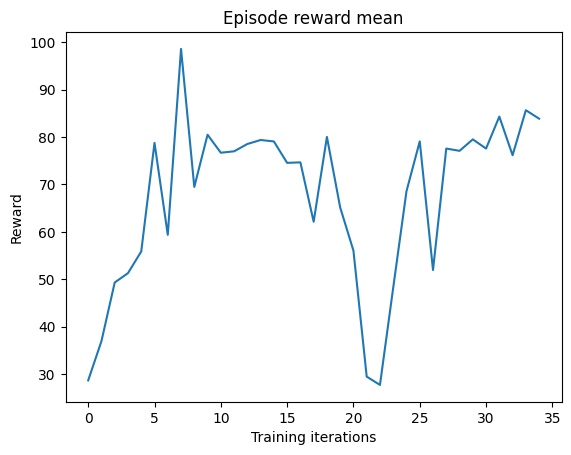

In [ ]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.savefig('episode_reward_mean'+str(time)+'.png')
plt.show()

In [ ]:
!pip3 install torchvision
!pip3 install av

In [ ]:
from torchrl.record import VideoRecorder
from torchrl.record.loggers.csv import CSVLogger
from torchrl.envs import TransformedEnv
import pyvirtualdisplay

display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()

env = GymEnv(
    env_name=scenario_name,
    device=gym_device,
    from_pixels=True,
    pixels_only=False,
)

logger = CSVLogger(exp_name=scenario_name, log_dir=scenario_name+"_policy", video_format="mp4") # log_dir is the directory where the videos will be saved

vr_transformation = VideoRecorder(logger=logger, out_keys='obs', tag="run_video")
df_transformation = DoubleToFloat()

env = TransformedEnv(env, vr_transformation)
env = TransformedEnv(env, df_transformation)
                                
n_rollout_steps = max_steps
with torch.no_grad():
    rollout = env.rollout(n_rollout_steps,
        policy=policy,
        auto_cast_to_device=True,
        break_when_any_done=False,)
vr_transformation.dump()
# read mp4 video
import io
import base64
from IPython.display import HTML
video = io.open(scenario_name+"_policy"+"/"+scenario_name+'/videos/run_video_0.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

/home/codespace/.python/current/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(
